In [1]:
import pandas as pd
from pandas import Series, DataFrame
import json 
import os
import requests 
import math
import sqlite3
import copy
import re
import seaborn as sns
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
matplotlib.rcParams.update({'font.size': 15})

In [2]:
#code references for the new data
coderef = pd.read_csv("newbudget1codereferences.csv")
#services provided per planning
planningservice = coderef[coderef["Agency"]== "65 -  PLANNING"].copy()
planningservice.head()

,Organization,Agency,Service,Subservice,Location
513,65101 - PL NEIGH PLAN PRES DESIGN ADMI,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6501 - ADMINISTRATION,0000 - UNDEFINED
514,65110 - PL NEIGHBORHOOD PLANNING,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6510 - NEIGHBORHOOD PLANNING,0000 - UNDEFINED
515,65111 - PL PRESERVATION PLANNING,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6511 - PRESERVATION PLANNING,0000 - UNDEFINED
516,65112 - PL MADISON ARTS PROGRAM,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6512 - MADISON ARTS PROGRAM,0000 - UNDEFINED
517,65113 - PL URBAN DESIGN COMMISSION,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6513 - URBAN DESIGN COMMISSION,0000 - UNDEFINED


In [3]:
#origional data 
madisonfinancedf = pd.read_csv("budget.csv")
madisonfinancedf.head()

,Agency,Organization,Account Type,Character Code,Object,2015,2016,2017,2018
0,50 - LIBRARY,50100 - LIB PUBLIC SERVICE,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-11355535.00,-11941627.00,-12603779.00,-13080447.90
1,50 - LIBRARY,50300 - LIB COL RES & ACCESS,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-2056164.00,-2222626.00,-2199357.00,-2268968.77
2,50 - LIBRARY,50400 - LIB FACILITIES,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-1766869.00,-1768986.00,-1963404.00,-1976738.18
3,51 - PARKS,51220 - PARK MTC FORESTRY GENERAL,Revenue,49 - TRANSFER IN,49124 - TRANSFER IN FROM OTHER RESTRIC,-1000000.00,-2500000.00,-3100342.25,0.00
4,44 - STREETS,44220 - ST RECYCLING COLLECTION,Revenue,43 - CHARGES FOR SERVICES,43445 - SALE OF RECYCLABLES,-841012.69,-866760.77,-1218608.41,-892803.25


In [4]:
#copy of origional data
mfdf = madisonfinancedf.copy()
mfdf = pd.DataFrame(mfdf)
mfdf = mfdf.sort_values('Agency')
mfdf.head()


,Agency,Organization,Account Type,Character Code,Object,2015,2016,2017,2018
8326,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,58 - INTER DEPART BILLING,58180 - ID BILLING TO MONONA TERRACE,NaN,NaN,NaN,0.0
1761,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,52 - BENEFITS,52715 - GRANT,0.00,780.68,0.00,0.0
8332,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,58 - INTER DEPART BILLING,58186 - ID BILLING TO WATER,NaN,NaN,NaN,0.0
6928,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,54 - PURCHASED SERVICES,54645 - CONSULTING SERVICES,68531.03,75298.12,72167.32,83768.3
8331,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,58 - INTER DEPART BILLING,58185 - ID BILLING TO TRANSIT,NaN,NaN,NaN,0.0


In [5]:
#Cleaning up the data
mfdf["Agency"] = mfdf["Agency"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Organization"]= mfdf["Organization"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Character Code"]= mfdf["Character Code"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Object"]=mfdf["Object"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf.head()

,Agency,Organization,Account Type,Character Code,Object,2015,2016,2017,2018
8326,UNDEFINED,GENERAL FUND EXPENSE,Expense,INTER DEPART BILLING,ID BILLING TO MONONA TERRACE,NaN,NaN,NaN,0.0
1761,UNDEFINED,GENERAL FUND EXPENSE,Expense,BENEFITS,GRANT,0.00,780.68,0.00,0.0
8332,UNDEFINED,GENERAL FUND EXPENSE,Expense,INTER DEPART BILLING,ID BILLING TO WATER,NaN,NaN,NaN,0.0
6928,UNDEFINED,GENERAL FUND EXPENSE,Expense,PURCHASED SERVICES,CONSULTING SERVICES,68531.03,75298.12,72167.32,83768.3
8331,UNDEFINED,GENERAL FUND EXPENSE,Expense,INTER DEPART BILLING,ID BILLING TO TRANSIT,NaN,NaN,NaN,0.0


In [6]:
#data frame for planning yearly budget by charactercodes 
agency = mfdf[mfdf['Agency']=="PLANNING"]
agency1 = mfdf[mfdf['Agency']=="COMMUNITY DEVELOPMENT"]
agencydic= {"2015": {}, "2016": {} , "2017": {} , "2018": {} }
for year in agencydic:
    for code in agency["Organization"]:
        if code not in agencydic[year]:
            a = agency[agency["Organization"]==code]
            summ = a[year].sum()
            agencydic[year][code] = copy.deepcopy(summ)
adf = pd.DataFrame(agencydic["2015"], index=["2015"])
bdf = pd.DataFrame(agencydic["2016"], index=["2016"])
cdf = pd.DataFrame(agencydic["2017"], index=["2017"])
ddf = pd.DataFrame(agencydic["2018"], index=["2018"])
planyearorg = pd.concat([adf, bdf, cdf, ddf])
planyearorg=planyearorg/1000000

planyearorg


,PL METROPOLITAN PLANNING ORG,PL NEIGH PLAN PRES DESIGN ADMI,PL COMP NEIGH SPEC AREA PLAN,PL NEIGHBORHOOD PLANNING,PL TRANSPORTATION PLAN NON MPO,PL COMP PLAN AND DEVELOP ADMIN,PL PRESERVATION PLANNING,PL SPECIAL PROJECTS,PL RESEARCH INFORMATION SERVIC,PL PLAN COMMISSION DEV REVIEW,PL GEO GIS ADMINISTRATION MAIN,PL URBAN DESIGN COMMISSION,PL MADISON ARTS PROGRAM,PL TIF CDA REDEVELOPMENT PLAN,PL DEVELP LAND USE ZONING REG,PL LAND USE POLICY INTERGOV PL
2015,0.283503,0.297465,0.219246,0.252465,0.134689,0.340130,0.109043,0.212096,0.225441,0.296121,0.106075,0.111734,1.942465,0.000000,0.0,0.0
2016,0.258890,0.335264,0.365725,0.281964,0.203631,0.418839,0.108182,0.301593,0.191919,0.236606,0.048955,0.110497,0.182965,0.000000,0.0,0.0
2017,0.140959,0.377865,0.480060,0.360768,0.221787,0.603246,0.117936,0.100695,0.162118,0.196876,0.087631,0.005203,0.218855,0.000025,0.0,0.0
2018,0.094496,0.421926,0.420081,0.377337,0.365577,0.568047,0.078490,0.127823,0.109070,0.298799,0.102560,0.000000,0.202924,0.000000,0.0,0.0


In [7]:
a=planyearorg.transpose()
a.reset_index(level=0, inplace=True)
a["index"]

0       PL METROPOLITAN PLANNING ORG
1     PL NEIGH PLAN PRES DESIGN ADMI
2       PL COMP NEIGH SPEC AREA PLAN
3           PL NEIGHBORHOOD PLANNING
4     PL TRANSPORTATION PLAN NON MPO
5     PL COMP PLAN AND DEVELOP ADMIN
6           PL PRESERVATION PLANNING
7                PL SPECIAL PROJECTS
8     PL RESEARCH INFORMATION SERVIC
9      PL PLAN COMMISSION DEV REVIEW
10    PL GEO GIS ADMINISTRATION MAIN
11        PL URBAN DESIGN COMMISSION
12           PL MADISON ARTS PROGRAM
13     PL TIF CDA REDEVELOPMENT PLAN
14     PL DEVELP LAND USE ZONING REG
15    PL LAND USE POLICY INTERGOV PL
Name: index, dtype: object

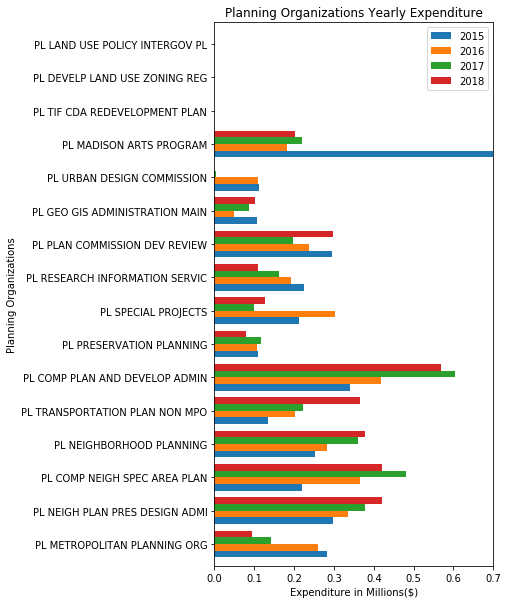

In [8]:
#planning organizations by yearly expenditure horizontal bar 
data=planyearorg.T.plot.barh(figsize=(5,10),title="Planning Organizations Yearly Expenditure", width=0.8) 
data.set_ylabel("Planning Organizations")
data.set_xlabel("Expenditure in Millions($)")
data.set_xlim(0,0.7)
data.legend(loc='upper right')

In [9]:
#http://data-cityofmadison.opendata.arcgis.com/datasets/43743f819e1d4e7ab35a202e442cf27c_28/data
#Data from city of madison on Bus Rapid Routes 
#Planning Transportation MPO
#https://www.cityofmadison.com/dpced/planning/documents/MIM%20priority%20recomendations.pdf
import pandas
from pandas.io.json import json_normalize

res = requests.get("https://opendata.arcgis.com/datasets/43743f819e1d4e7ab35a202e442cf27c_28.geojson")
j = res.json()

dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("busrapidtransitstops.csv", encoding='utf-8', index=False)            
rbusdata=pd.read_csv("busrapidtransitstops.csv")
rbusdata=rbusdata.set_index(rbusdata["OBJECTID"])
rbusdata["Notes"] = rbusdata['Notes'].fillna("")
rbusdata["MetroID"] = rbusdata['MetroID'].fillna(0)
rbusdata.head()

,MetroID,Notes,OBJECTID,coordinates,stop_id,stop_lat,stop_lon,stop_name
OBJECTID,,,,,,,,
1,809.0,,1,"[-89.4110859632727, 43.07325805819196]",91001,43.073258,-89.411086,EB CAMPUS ns BABCOCK RR
2,741.0,,2,"[-89.4043089661151, 43.072085058177706]",91002,43.072085,-89.404309,EB W JOHNSON ns MILLS
3,455.0,,3,"[-89.400131967395, 43.07201905809875]",91003,43.072019,-89.400132,EB W JOHNSON fs N PARK
4,555.0,,4,"[-89.39329196869723, 43.072363057733206]",91004,43.072363,-89.393292,EB W JOHNSON fs BASSETT
5,883.0,,5,"[-89.3882599703234, 43.07470505644012]",91005,43.074705,-89.388260,EB STATE ns FAIRCHILD


In [10]:
#number of people commute data 
#http://data-cityofmadison.opendata.arcgis.com/datasets/2bfd47ada14542c5969a6eb7e6f274dd_31/data?geometry=-89.544%2C43.049%2C-89.283%2C43.093
res = requests.get("https://opendata.arcgis.com/datasets/2bfd47ada14542c5969a6eb7e6f274dd_31.geojson")
jj = res.json()

dic= []
for object in jj["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("workplacedata.csv", encoding='utf-8', index=False)            
wpdata=pd.read_csv("workplacedata.csv")
wpdata=wpdata.set_index(wpdata["OBJECTID"])
wpdata.head()
#drop duplicates and check len


,Bicycle,Bus,Carpool2,Carpool3,Carpool4,Carpool5,Carpool7,DES_ID,DES_ID_1,DES_LENGTH,...,Rail,ShapeSTLength,Subway,Taxi,Total,Trolley,WORKPLACE,Walked,WorkedHome,coordinates
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,14888.338340,...,0.0,14888.338340,0.0,0.0,10.0,0.0,"Census Tract 10, Dane County, Wisconsin",0.0,0.0,"[[-89.47539185715189, 43.08293455103483], [-89..."
2,0.0,25.0,0.0,0.0,0.0,0.0,0.0,101.0,101.0,7271.941348,...,0.0,7271.941348,0.0,0.0,35.0,0.0,"Census Tract 101, Dane County, Wisconsin",0.0,0.0,"[[-89.47539185715189, 43.08293455103483], [-89..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,102.0,30090.845436,...,NaN,30090.845436,NaN,NaN,NaN,NaN,"Census Tract 102, Dane County, Wisconsin",NaN,NaN,"[[-89.47539185715189, 43.08293455103483], [-89..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.0,103.0,37615.520001,...,NaN,37615.520001,NaN,NaN,NaN,NaN,"Census Tract 103, Dane County, Wisconsin",NaN,NaN,"[[-89.47539185715189, 43.08293455103483], [-89..."
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,104.0,39009.663787,...,NaN,39009.663787,NaN,NaN,NaN,NaN,"Census Tract 104, Dane County, Wisconsin",NaN,NaN,"[[-89.47539185715189, 43.08293455103483], [-89..."


In [11]:
#NEED HELP INTERPERETING the rapid bus dicionary snippet. In the above codes, I copied the gemetry{"coordinates"} 
#and input them in the new properties{"coordinates"}. That is why there are two identical coordinates. 
#
for object in j["features"]:
    print(object)
    break
#NEED HELP INTERPERETING the commute dicionary snippet.
for object in jj["features"]:
    print(object)
    break

{'type': 'Feature', 'properties': {'OBJECTID': 1, 'stop_id': 91001, 'stop_name': 'EB CAMPUS ns BABCOCK RR ', 'stop_lat': 43.07325806, 'stop_lon': -89.41108596, 'MetroID': 809, 'Notes': None, 'coordinates': [-89.4110859632727, 43.07325805819196]}, 'geometry': {'type': 'Point', 'coordinates': [-89.4110859632727, 43.07325805819196]}}
{'type': 'Feature', 'properties': {'OBJECTID': 1, 'ORG_ID': '1', 'DES_ID': '10', 'DES_LENGTH': 14888.33833972, 'ORG_DES_ID': '1_10', 'OBJECTID_1': 2141, 'WORKPLACE': 'Census Tract 10, Dane County, Wisconsin', 'RESIDENCE': 'Census Tract 1, Dane County, Wisconsin', 'Total': 10, 'DroveAlone': 10, 'Carpool2': 0, 'Carpool3': 0, 'Carpool4': 0, 'Carpool5': 0, 'Carpool7': 0, 'Bus': 0, 'Trolley': 0, 'Subway': 0, 'Rail': 0, 'Ferry': 0, 'Bicycle': 0, 'Walked': 0, 'Taxi': 0, 'Motorcycle': 0, 'Other': 0, 'WorkedHome': 0, 'ORG_ID_1': '1', 'DES_ID_1': '10', 'ORG_DES_ID_1': '1_10', 'ShapeSTLength': 14888.33833972415, 'coordinates': [[-89.47539185715189, 43.08293455103483], [

In [12]:
#data clean up 
dic = []
for coor in wpdata["coordinates"]:
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    #coor = coor.replace("-", "")
    coor = coor.split()
    dic.append(coor)
wpdata["coordinates"] = dic
dic = []
for coor in rbusdata["coordinates"]:
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    #coor = coor.replace("-", "")
    coor = coor.split()
    dic.append(coor)
rbusdata["coordinates"] = dic
wpdata.head()

,Bicycle,Bus,Carpool2,Carpool3,Carpool4,Carpool5,Carpool7,DES_ID,DES_ID_1,DES_LENGTH,...,Rail,ShapeSTLength,Subway,Taxi,Total,Trolley,WORKPLACE,Walked,WorkedHome,coordinates
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,14888.338340,...,0.0,14888.338340,0.0,0.0,10.0,0.0,"Census Tract 10, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.43..."
2,0.0,25.0,0.0,0.0,0.0,0.0,0.0,101.0,101.0,7271.941348,...,0.0,7271.941348,0.0,0.0,35.0,0.0,"Census Tract 101, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.44..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,102.0,30090.845436,...,NaN,30090.845436,NaN,NaN,NaN,NaN,"Census Tract 102, Dane County, Wisconsin",NaN,NaN,"[-89.47539185715189, 43.08293455103483, -89.37..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.0,103.0,37615.520001,...,NaN,37615.520001,NaN,NaN,NaN,NaN,"Census Tract 103, Dane County, Wisconsin",NaN,NaN,"[-89.47539185715189, 43.08293455103483, -89.33..."
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,104.0,39009.663787,...,NaN,39009.663787,NaN,NaN,NaN,NaN,"Census Tract 104, Dane County, Wisconsin",NaN,NaN,"[-89.47539185715189, 43.08293455103483, -89.33..."


In [13]:
#choosing locations that are 10 min away from bus stop from wpdata 
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in wpdata["OBJECTID"]:
    coordinates = wpdata[wpdata["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance <= 0.6:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(wpdata[wpdata["OBJECTID"]==index])
                       
datas=pd.concat(dic)
datas.head()                    
            

        

,Bicycle,Bus,Carpool2,Carpool3,Carpool4,Carpool5,Carpool7,DES_ID,DES_ID_1,DES_LENGTH,...,Rail,ShapeSTLength,Subway,Taxi,Total,Trolley,WORKPLACE,Walked,WorkedHome,coordinates
OBJECTID,,,,,,,,,,,,,,,,,,,,,
227,4.0,4.0,10.0,0.0,0.0,0.0,0.0,11.01,11.01,11461.41581,...,0.0,11461.41581,0.0,0.0,55.0,0.0,"Census Tract 11.01, Dane County, Wisconsin",10.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.407..."
227,4.0,4.0,10.0,0.0,0.0,0.0,0.0,11.01,11.01,11461.41581,...,0.0,11461.41581,0.0,0.0,55.0,0.0,"Census Tract 11.01, Dane County, Wisconsin",10.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.407..."
227,4.0,4.0,10.0,0.0,0.0,0.0,0.0,11.01,11.01,11461.41581,...,0.0,11461.41581,0.0,0.0,55.0,0.0,"Census Tract 11.01, Dane County, Wisconsin",10.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.407..."
227,4.0,4.0,10.0,0.0,0.0,0.0,0.0,11.01,11.01,11461.41581,...,0.0,11461.41581,0.0,0.0,55.0,0.0,"Census Tract 11.01, Dane County, Wisconsin",10.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.407..."
227,4.0,4.0,10.0,0.0,0.0,0.0,0.0,11.01,11.01,11461.41581,...,0.0,11461.41581,0.0,0.0,55.0,0.0,"Census Tract 11.01, Dane County, Wisconsin",10.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.407..."


In [14]:
data = copy.deepcopy(datas)
data=data.drop_duplicates(subset=["OBJECTID"], keep="first")
data

    

,Bicycle,Bus,Carpool2,Carpool3,Carpool4,Carpool5,Carpool7,DES_ID,DES_ID_1,DES_LENGTH,...,Rail,ShapeSTLength,Subway,Taxi,Total,Trolley,WORKPLACE,Walked,WorkedHome,coordinates
OBJECTID,,,,,,,,,,,,,,,,,,,,,
227,4.0,4.0,10.0,0.0,0.0,0.0,0.0,11.01,11.01,11461.415810,...,0.0,11461.415810,0.0,0.0,55.0,0.0,"Census Tract 11.01, Dane County, Wisconsin",10.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.407..."
228,30.0,10.0,4.0,4.0,0.0,0.0,0.0,11.02,11.02,10098.812767,...,0.0,10098.812767,0.0,0.0,130.0,0.0,"Census Tract 11.02, Dane County, Wisconsin",20.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.411..."
245,4.0,0.0,4.0,0.0,0.0,0.0,0.0,12.00,12.00,12597.458649,...,0.0,12597.458649,0.0,0.0,30.0,0.0,"Census Tract 12, Dane County, Wisconsin",0.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.406..."
259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.00,13.00,18097.236747,...,NaN,18097.236747,NaN,NaN,NaN,NaN,"Census Tract 13, Dane County, Wisconsin",NaN,NaN,"[-89.4487037217782, 43.07901968394355, -89.390..."
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.01,14.01,20694.631403,...,NaN,20694.631403,NaN,NaN,NaN,NaN,"Census Tract 14.01, Dane County, Wisconsin",NaN,NaN,"[-89.4487037217782, 43.07901968394355, -89.387..."
268,4.0,0.0,0.0,0.0,0.0,0.0,0.0,14.03,14.03,24068.005359,...,0.0,24068.005359,0.0,0.0,4.0,0.0,"Census Tract 14.03, Dane County, Wisconsin",0.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.414..."
271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.03,16.03,14381.497079,...,NaN,14381.497079,NaN,NaN,NaN,NaN,"Census Tract 16.03, Dane County, Wisconsin",NaN,NaN,"[-89.4487037217782, 43.07901968394355, -89.395..."
272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.04,16.04,15114.743645,...,NaN,15114.743645,NaN,NaN,NaN,NaN,"Census Tract 16.04, Dane County, Wisconsin",NaN,NaN,"[-89.4487037217782, 43.07901968394355, -89.392..."
274,4.0,0.0,0.0,0.0,0.0,0.0,0.0,16.06,16.06,14545.485548,...,0.0,14545.485548,0.0,0.0,10.0,0.0,"Census Tract 16.06, Dane County, Wisconsin",0.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.395..."


Bicycle        2159.0
Bus            2707.0
Carpool2        827.0
Carpool3         94.0
Carpool4         34.0
Carpool5         40.0
Carpool7         15.0
DroveAlone     6040.0
Ferry            15.0
Motorcycle       58.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         17905.0
Trolley           0.0
Walked         5814.0
WorkedHome        0.0
dtype: float64


Text(0.5, 0, 'Number of commuters')

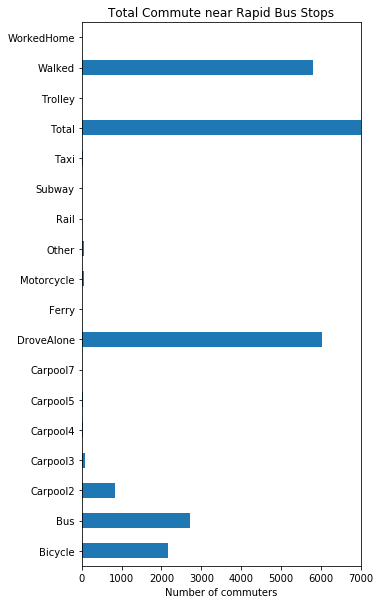

In [15]:
data.sort_values(by="Bus", ascending=False)
data1 = copy.deepcopy(data)
data1.drop('DES_ID', axis=1, inplace=True)
data1.drop('DES_ID_1', axis=1, inplace=True)
data1.drop('DES_LENGTH', axis=1, inplace=True)
data1.drop('OBJECTID_1', axis=1, inplace=True)
data1.drop('OBJECTID', axis=1, inplace=True)
data1.drop('ORG_DES_ID', axis=1, inplace=True)
data1.drop('ORG_DES_ID_1', axis=1, inplace=True)
data1.drop('ORG_ID', axis=1, inplace=True)
data1.drop('ORG_ID_1', axis=1, inplace=True)
data1.drop('RESIDENCE', axis=1, inplace=True)
data1.drop('ShapeSTLength', axis=1, inplace=True)
data1.drop('WORKPLACE', axis=1, inplace=True)
data1.drop('coordinates', axis=1, inplace=True)
data1=data1.sum()
print(data1)
fig, ax = subplots()
dataplot1=data1.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot1
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot1.set_xlabel("Number of commuters")

In [16]:
#eliminating people who have work 10 min distance from their home
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
dic20= []
dic30=[]
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in data["OBJECTID"]:
    coordinates = data[data["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for coor in coordinates:                    
        lat1 = radians(float(coor[1]))
        lon1 = radians(float(coor[0]))
        lat2 = radians(float(coor[3]))
        lon2 = radians(float(coor[2]))
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        if 0.6 <= distance:
            dic.append(data[data["OBJECTID"]==index])
        if 1.2 <= distance:
            dic20.append(data[data["OBJECTID"]==index])
        if 1.8 <= distance:
            dic30.append(data[data["OBJECTID"]==index])            
data3=pd.concat(dic20)
data4=pd.concat(dic30)
data2=pd.concat(dic)
data2                    
            

        

,Bicycle,Bus,Carpool2,Carpool3,Carpool4,Carpool5,Carpool7,DES_ID,DES_ID_1,DES_LENGTH,...,Rail,ShapeSTLength,Subway,Taxi,Total,Trolley,WORKPLACE,Walked,WorkedHome,coordinates
OBJECTID,,,,,,,,,,,,,,,,,,,,,
227,4.0,4.0,10.0,0.0,0.0,0.0,0.0,11.01,11.01,11461.415810,...,0.0,11461.415810,0.0,0.0,55.0,0.0,"Census Tract 11.01, Dane County, Wisconsin",10.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.407..."
228,30.0,10.0,4.0,4.0,0.0,0.0,0.0,11.02,11.02,10098.812767,...,0.0,10098.812767,0.0,0.0,130.0,0.0,"Census Tract 11.02, Dane County, Wisconsin",20.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.411..."
245,4.0,0.0,4.0,0.0,0.0,0.0,0.0,12.00,12.00,12597.458649,...,0.0,12597.458649,0.0,0.0,30.0,0.0,"Census Tract 12, Dane County, Wisconsin",0.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.406..."
259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.00,13.00,18097.236747,...,NaN,18097.236747,NaN,NaN,NaN,NaN,"Census Tract 13, Dane County, Wisconsin",NaN,NaN,"[-89.4487037217782, 43.07901968394355, -89.390..."
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.01,14.01,20694.631403,...,NaN,20694.631403,NaN,NaN,NaN,NaN,"Census Tract 14.01, Dane County, Wisconsin",NaN,NaN,"[-89.4487037217782, 43.07901968394355, -89.387..."
268,4.0,0.0,0.0,0.0,0.0,0.0,0.0,14.03,14.03,24068.005359,...,0.0,24068.005359,0.0,0.0,4.0,0.0,"Census Tract 14.03, Dane County, Wisconsin",0.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.414..."
271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.03,16.03,14381.497079,...,NaN,14381.497079,NaN,NaN,NaN,NaN,"Census Tract 16.03, Dane County, Wisconsin",NaN,NaN,"[-89.4487037217782, 43.07901968394355, -89.395..."
272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.04,16.04,15114.743645,...,NaN,15114.743645,NaN,NaN,NaN,NaN,"Census Tract 16.04, Dane County, Wisconsin",NaN,NaN,"[-89.4487037217782, 43.07901968394355, -89.392..."
274,4.0,0.0,0.0,0.0,0.0,0.0,0.0,16.06,16.06,14545.485548,...,0.0,14545.485548,0.0,0.0,10.0,0.0,"Census Tract 16.06, Dane County, Wisconsin",0.0,0.0,"[-89.4487037217782, 43.07901968394355, -89.395..."


Bicycle        2104.0
Bus            2692.0
Carpool2        812.0
Carpool3         94.0
Carpool4         34.0
Carpool5         40.0
Carpool7         15.0
DroveAlone     5960.0
Ferry            15.0
Motorcycle       58.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         17460.0
Trolley           0.0
Walked         5534.0
WorkedHome        0.0
dtype: float64


Text(0.5, 0, 'Number of commuters')

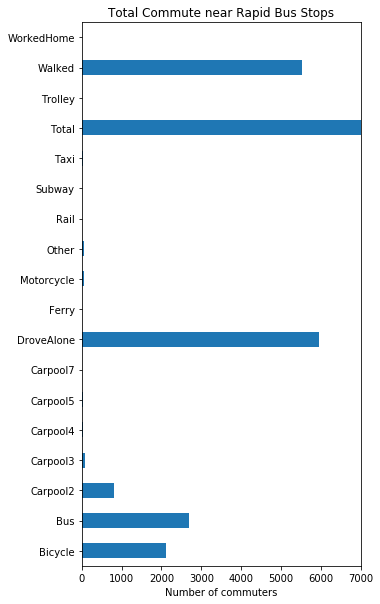

In [17]:
data2.sort_values(by="Bus", ascending=False)
data2 = copy.deepcopy(data2)
data2.drop('DES_ID', axis=1, inplace=True)
data2.drop('DES_ID_1', axis=1, inplace=True)
data2.drop('DES_LENGTH', axis=1, inplace=True)
data2.drop('OBJECTID_1', axis=1, inplace=True)
data2.drop('OBJECTID', axis=1, inplace=True)
data2.drop('ORG_DES_ID', axis=1, inplace=True)
data2.drop('ORG_DES_ID_1', axis=1, inplace=True)
data2.drop('ORG_ID', axis=1, inplace=True)
data2.drop('ORG_ID_1', axis=1, inplace=True)
data2.drop('RESIDENCE', axis=1, inplace=True)
data2.drop('ShapeSTLength', axis=1, inplace=True)
data2.drop('WORKPLACE', axis=1, inplace=True)
data2.drop('coordinates', axis=1, inplace=True)
data2=data2.sum()
print(data2)
fig, ax = subplots()
dataplot2=data2.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot2
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot2.set_xlabel("Number of commuters")

Bicycle        1759.0
Bus            2537.0
Carpool2        793.0
Carpool3         94.0
Carpool4         34.0
Carpool5         40.0
Carpool7         15.0
DroveAlone     5795.0
Ferry            15.0
Motorcycle       58.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         15000.0
Trolley           0.0
Walked         3759.0
WorkedHome        0.0
dtype: float64


Text(0.5, 0, 'Number of commuters')

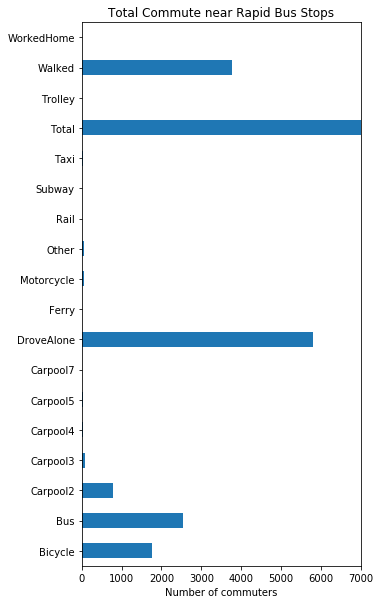

In [18]:
data3.sort_values(by="Bus", ascending=False)
data3 = copy.deepcopy(data3)
data3.drop('DES_ID', axis=1, inplace=True)
data3.drop('DES_ID_1', axis=1, inplace=True)
data3.drop('DES_LENGTH', axis=1, inplace=True)
data3.drop('OBJECTID_1', axis=1, inplace=True)
data3.drop('OBJECTID', axis=1, inplace=True)
data3.drop('ORG_DES_ID', axis=1, inplace=True)
data3.drop('ORG_DES_ID_1', axis=1, inplace=True)
data3.drop('ORG_ID', axis=1, inplace=True)
data3.drop('ORG_ID_1', axis=1, inplace=True)
data3.drop('RESIDENCE', axis=1, inplace=True)
data3.drop('ShapeSTLength', axis=1, inplace=True)
data3.drop('WORKPLACE', axis=1, inplace=True)
data3.drop('coordinates', axis=1, inplace=True)
data3=data3.sum()
print(data3)
fig, ax = subplots()
dataplot3=data3.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot3
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot3.set_xlabel("Number of commuters")

Bicycle        1184.0
Bus            1918.0
Carpool2        688.0
Carpool3         94.0
Carpool4         34.0
Carpool5          0.0
Carpool7         15.0
DroveAlone     5226.0
Ferry            15.0
Motorcycle       43.0
Other            69.0
Rail              0.0
Subway            0.0
Taxi             40.0
Total         10495.0
Trolley           0.0
Walked         1164.0
WorkedHome        0.0
dtype: float64


Text(0.5, 0, 'Number of commuters')

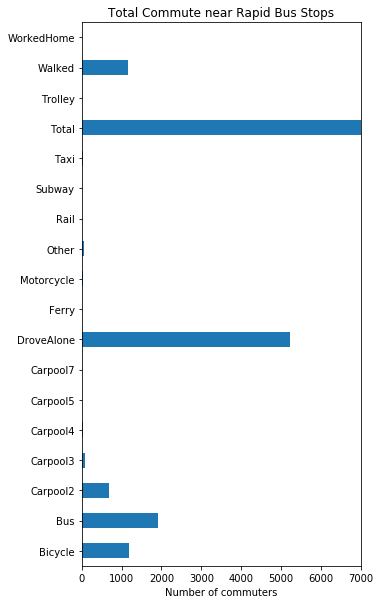

In [19]:
data4.sort_values(by="Bus", ascending=False)
data4 = copy.deepcopy(data4)
data4.drop('DES_ID', axis=1, inplace=True)
data4.drop('DES_ID_1', axis=1, inplace=True)
data4.drop('DES_LENGTH', axis=1, inplace=True)
data4.drop('OBJECTID_1', axis=1, inplace=True)
data4.drop('OBJECTID', axis=1, inplace=True)
data4.drop('ORG_DES_ID', axis=1, inplace=True)
data4.drop('ORG_DES_ID_1', axis=1, inplace=True)
data4.drop('ORG_ID', axis=1, inplace=True)
data4.drop('ORG_ID_1', axis=1, inplace=True)
data4.drop('RESIDENCE', axis=1, inplace=True)
data4.drop('ShapeSTLength', axis=1, inplace=True)
data4.drop('WORKPLACE', axis=1, inplace=True)
data4.drop('coordinates', axis=1, inplace=True)
data4=data4.sum()
print(data4)
fig, ax = subplots()
dataplot4=data4.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot4
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot4.set_xlabel("Number of commuters")

In [20]:
#number of commute comparrason 
stack=pd.concat([data1, data2, data3, data4],axis=1, join_axes=[data1.index])
stack=pd.DataFrame(stack)
stack.columns = ['None', '10 min', '20 min', "30 min"]
stack=stack.transpose()
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)
stack.drop('Total', axis=1, inplace=True)
stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)
stack

,Bicycle,Bus,Carpool2,Carpool3,DroveAlone,Walked
None,2159.0,2707.0,827.0,94.0,6040.0,5814.0
10 min,2104.0,2692.0,812.0,94.0,5960.0,5534.0
20 min,1759.0,2537.0,793.0,94.0,5795.0,3759.0
30 min,1184.0,1918.0,688.0,94.0,5226.0,1164.0


Text(0.5, 0, 'Number of commuters')

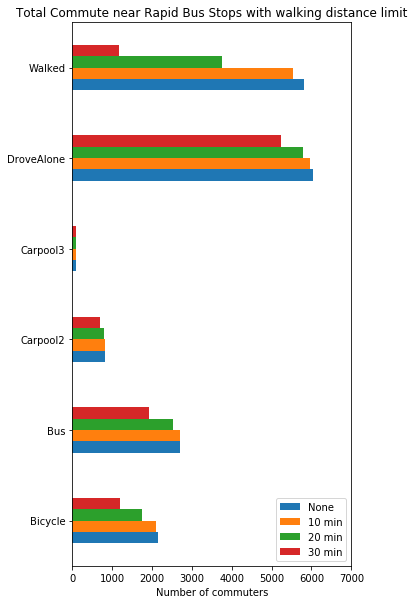

In [21]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops with walking distance limit",xlim=(0,7000), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [22]:
#percentage of commute 
data1=data1/data1["Total"]
data2=data2/data2["Total"]
data3=data3/data3["Total"]
data4=data4/data4["Total"]
stack=pd.concat([data1, data2, data3, data4],axis=1, join_axes=[data1.index])
stack=pd.DataFrame(stack)
stack.columns = ['None', '10 min', '20 min', "30 min"]
stack=stack.transpose()
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)
stack.drop('Total', axis=1, inplace=True)
stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)
stack

,Bicycle,Bus,Carpool2,Carpool3,DroveAlone,Walked
None,0.120581,0.151187,0.046188,0.005250,0.337336,0.324714
10 min,0.120504,0.154181,0.046506,0.005384,0.341352,0.316953
20 min,0.117267,0.169133,0.052867,0.006267,0.386333,0.250600
30 min,0.112816,0.182754,0.065555,0.008957,0.497951,0.110910


Text(0.5, 0, 'Number of commuters')

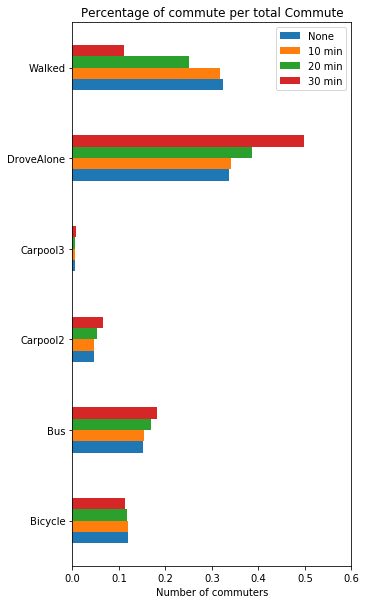

In [23]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Percentage of commute per total Commute",xlim=(0,0.6), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [24]:
import pandas as pd
import geopandas # we'll use this to read shapefiles
from shapely.geometry import Point

# the City_Limit directory contains some shapefiles.
# downloaded from here: http://data-cityofmadison.opendata.arcgis.com/datasets/city-limit
madison = geopandas.read_file("City_Limit")
madison.head()


,OBJECTID,SHAPESTAre,SHAPESTLen,geometry
0,1312,5.274004e+05,3.378551e+03,POLYGON ((-89.36924133213829 43.10153277072625...
1,1313,2.675664e+04,7.126214e+02,POLYGON ((-89.28523345356945 43.02112710884431...
2,1314,1.488101e+05,3.297256e+03,POLYGON ((-89.28049139471618 43.11701006709443...
3,1315,2.259798e+09,1.133896e+06,"POLYGON ((-89.5331291634087 43.0857426328395, ..."


In [25]:
# downloaded from here: http://data-cityofmadison.opendata.arcgis.com/datasets/c46082b091a941f8b2ded1dd115a1a05_8
lakes = geopandas.read_file("Lakes_and_Rivers")
lakes.head()

,OBJECTID,SHAPESTAre,SHAPESTLen,geometry
0,1,39958.447479,782.327754,POLYGON ((-89.49887223021146 43.08164301711978...
1,2,31880.854431,797.842450,POLYGON ((-89.48481873925945 43.08431142416414...
2,3,3699.958649,814.712984,POLYGON ((-89.51718402551259 43.10277473207884...
3,4,1174.258911,797.157265,"POLYGON ((-89.5186932397623 43.10267727786282,..."
4,5,40693.432434,848.431555,POLYGON ((-89.54301597807076 43.10090510287239...


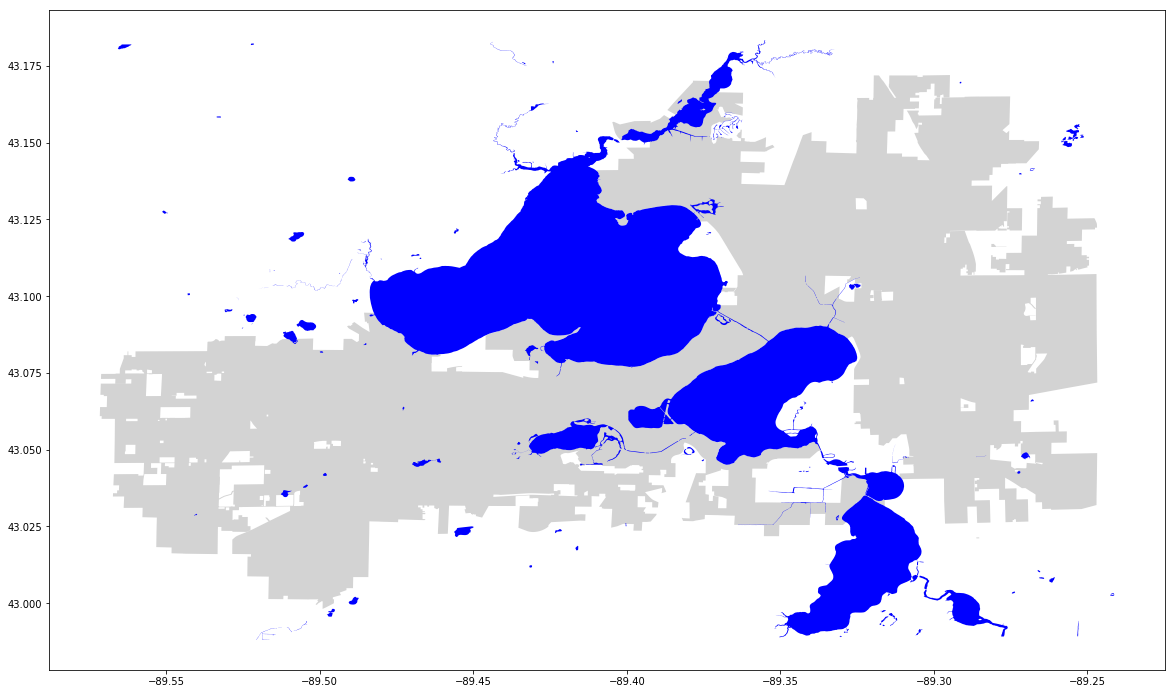

In [26]:
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)

In [27]:
# now lets annotate some buildings
coords = pd.Series([
    Point(-89.406749, 43.071478), # CS building
    Point(-89.384054, 43.074617), # Capital
])
print(coords)
buildings = pd.DataFrame({"Coordinates": coords})
buildings = geopandas.GeoDataFrame(buildings, geometry='Coordinates')
buildings

0            POINT (-89.406749 43.071478)
1    POINT (-89.38405400000001 43.074617)
dtype: object


,Coordinates
0,POINT (-89.406749 43.071478)
1,POINT (-89.38405400000001 43.074617)


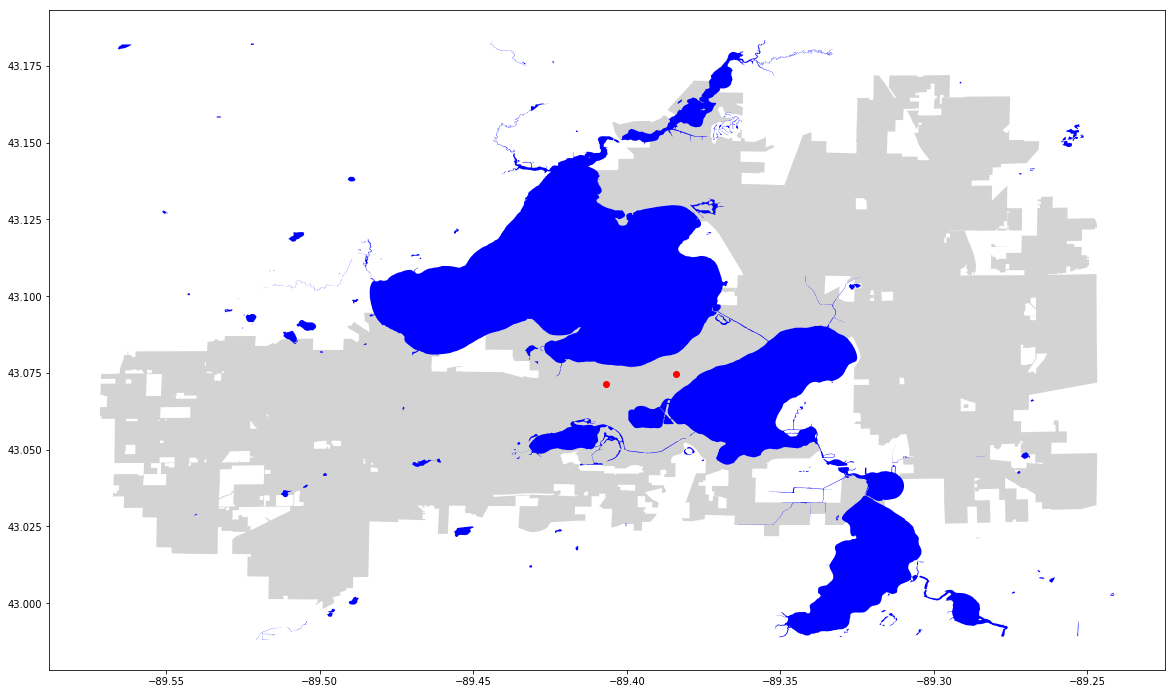

In [28]:
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
buildings.plot(color="red", ax=ax)

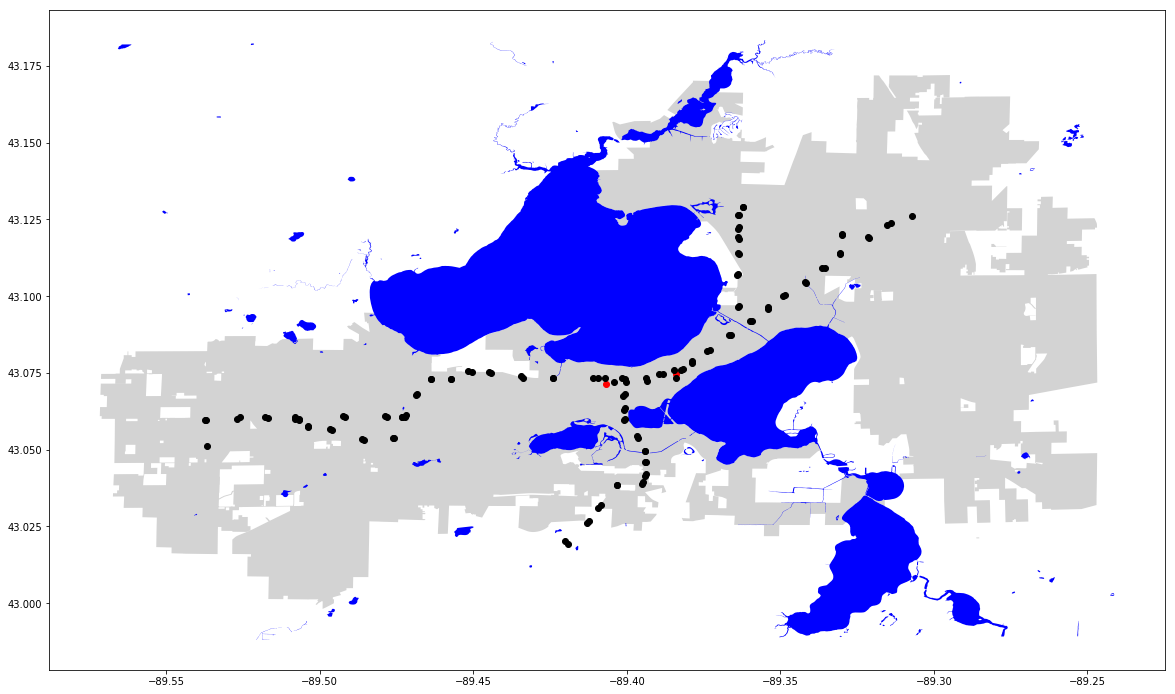

In [29]:
#annotate rapid bus stops 
dic = []
for coor in rbusdata["coordinates"]:
    dic.append(Point(float(coor[0]),float(coor[1])))
coords = pd.Series(dic)
bs = pd.DataFrame({"Coordinates": coords})
bs = geopandas.GeoDataFrame(bs, geometry='Coordinates')


ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
buildings.plot(color="red", ax=ax)
bs.plot(color="black", ax=ax)

In [30]:
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hcoords.head()

0    POINT (-89.4487037217782 43.07901968394355)
1    POINT (-89.4487037217782 43.07901968394355)
2    POINT (-89.4487037217782 43.07901968394355)
3    POINT (-89.4487037217782 43.07901968394355)
4    POINT (-89.4487037217782 43.07901968394355)
dtype: object

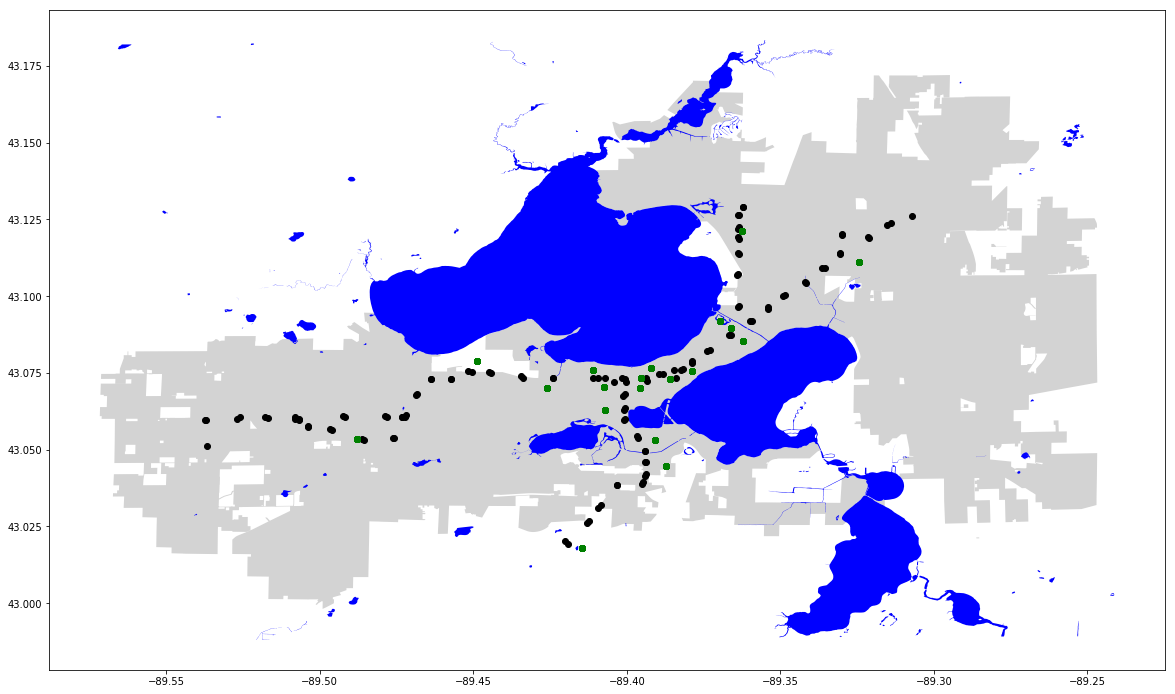

In [31]:
#annotate commute data  
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in data["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)


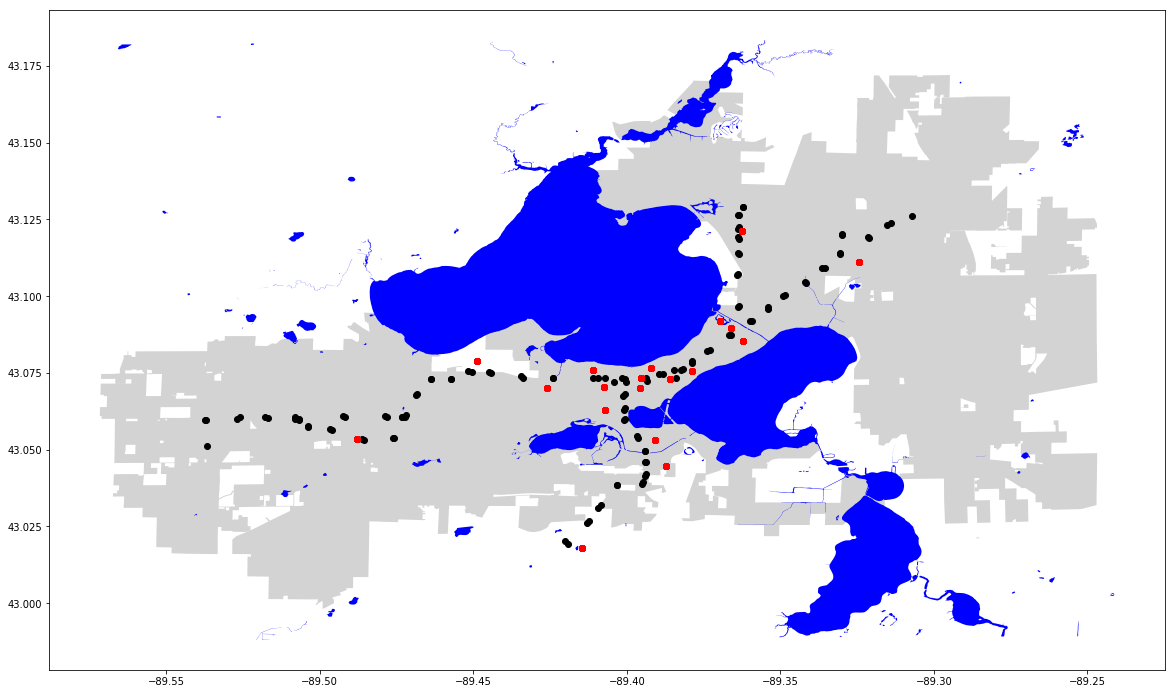

In [32]:
#annotate commute data  
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in data["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)
ws.plot(color="red", ax=ax)
#apparently, the work place and home coordinates are exactly the same so it overlaps, 
#only making one of the colors show... what?!

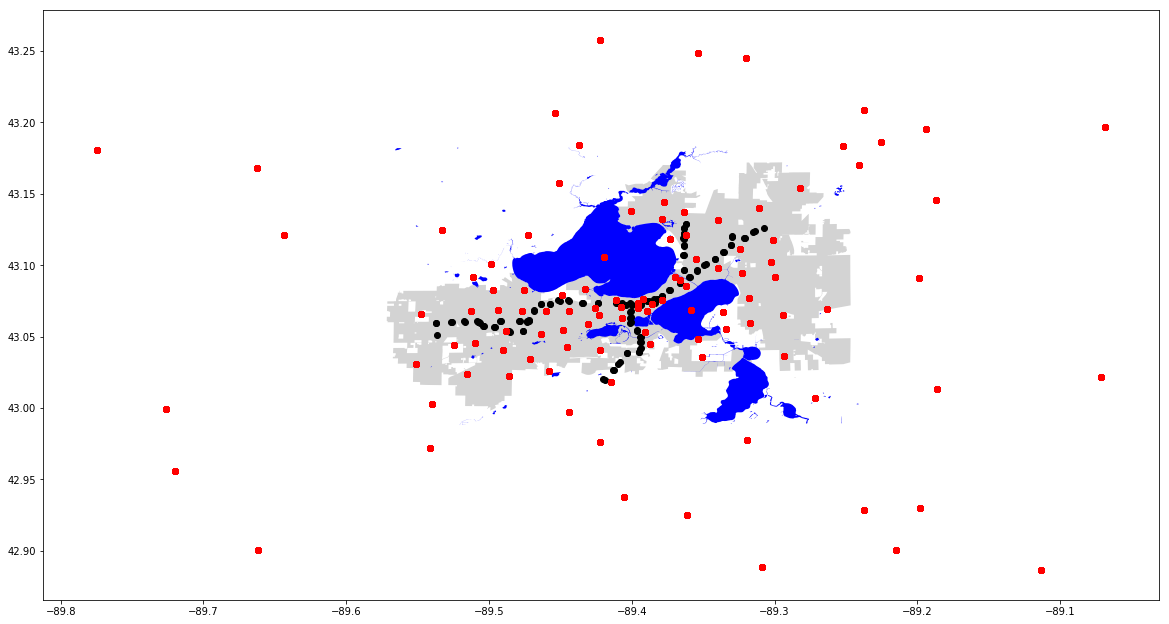

In [33]:
#annotate commute data from the origional wpdata
homedic = []
for coor in wpdata["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in wpdata["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)
ws.plot(color="red", ax=ax)
#again did not print due to the overlap. What is going on?? 

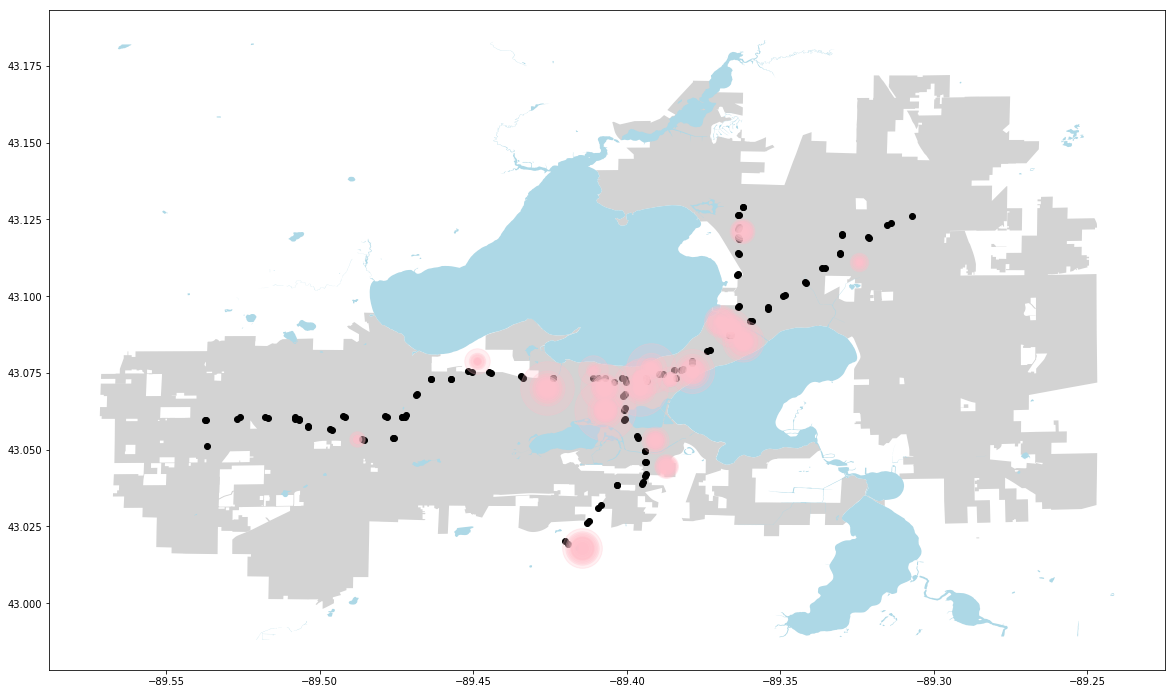

In [34]:
#annotate commute data from the origional wpdata
#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#mport random
#import string
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)

data.fillna(0, inplace=True)
dic = range(0, 350)
dic = list(dic)
i = 0
for index in data["OBJECTID"]:
    locat = data[data["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        #print(pop)
        #lettersAndDigits = string.ascii_letters + string.digits
        #counter =''.join(random.choice(lettersAndDigits) for i in range(10))
        #counter = hs
        dic[i].plot(color="pink", ax=ax, markersize=pop, alpha=0.25)
        i += 1
        

        
         
    
    


 


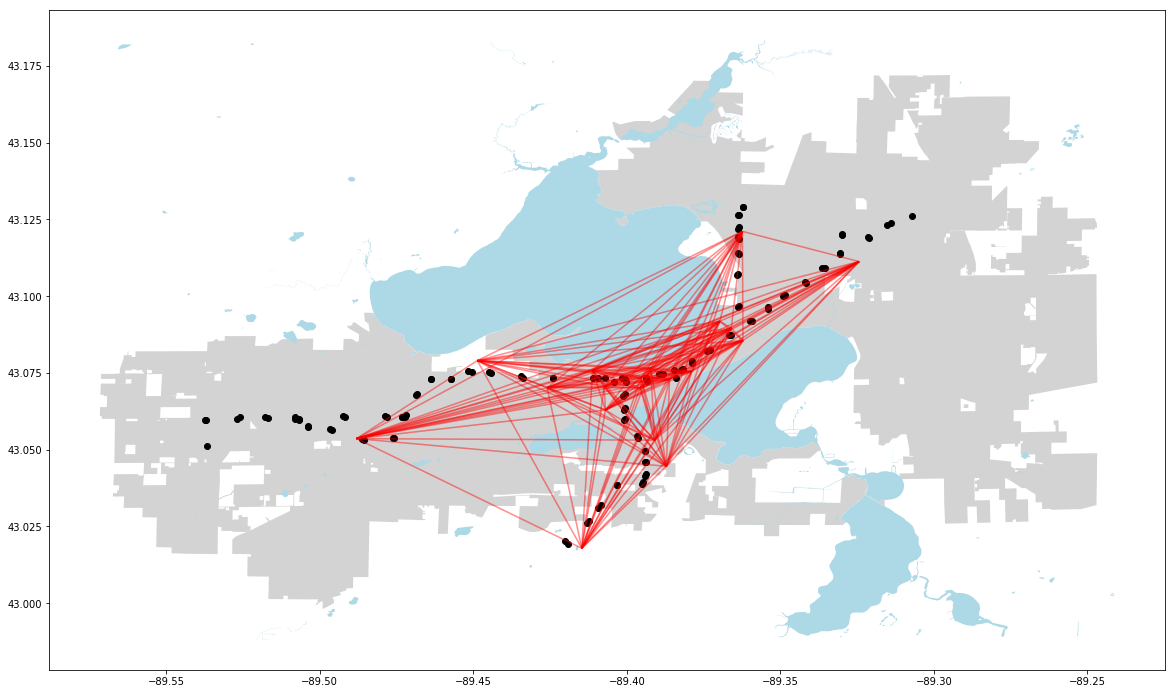

In [35]:
#################draw lines between the two coordinates to check relevence######################

#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#import random
#import string
from shapely.geometry import LineString

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)

data.fillna(0, inplace=True)
homedic = []
for index in data["OBJECTID"]:
    locat = data[data["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic.append(LineString([(float(coor[0]), float(coor[1])), (float(coor[2]), float(coor[3]))]))             
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.25)

        

In [36]:
wpdata.fillna(0, inplace=True)
wpdata.head()

,Bicycle,Bus,Carpool2,Carpool3,Carpool4,Carpool5,Carpool7,DES_ID,DES_ID_1,DES_LENGTH,...,Rail,ShapeSTLength,Subway,Taxi,Total,Trolley,WORKPLACE,Walked,WorkedHome,coordinates
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,14888.338340,...,0.0,14888.338340,0.0,0.0,10.0,0.0,"Census Tract 10, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.43..."
2,0.0,25.0,0.0,0.0,0.0,0.0,0.0,101.0,101.0,7271.941348,...,0.0,7271.941348,0.0,0.0,35.0,0.0,"Census Tract 101, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.44..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,102.0,30090.845436,...,0.0,30090.845436,0.0,0.0,0.0,0.0,"Census Tract 102, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.37..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,103.0,37615.520001,...,0.0,37615.520001,0.0,0.0,0.0,0.0,"Census Tract 103, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.33..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,104.0,39009.663787,...,0.0,39009.663787,0.0,0.0,0.0,0.0,"Census Tract 104, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.33..."


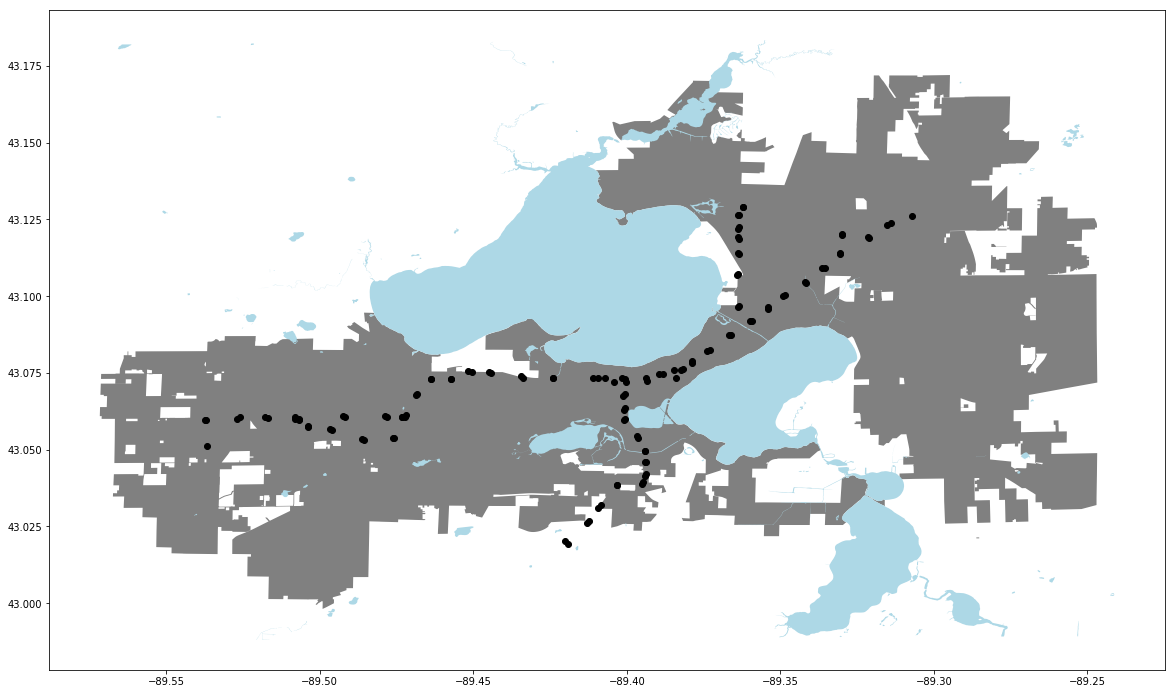

In [44]:
from shapely.geometry import LineString


homedic = []
for index in wpdata["OBJECTID"]:
    locat = wpdata[wpdata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic.append(LineString([(float(coor[0]), float(coor[1])), (float(coor[2]), float(coor[3]))]))             


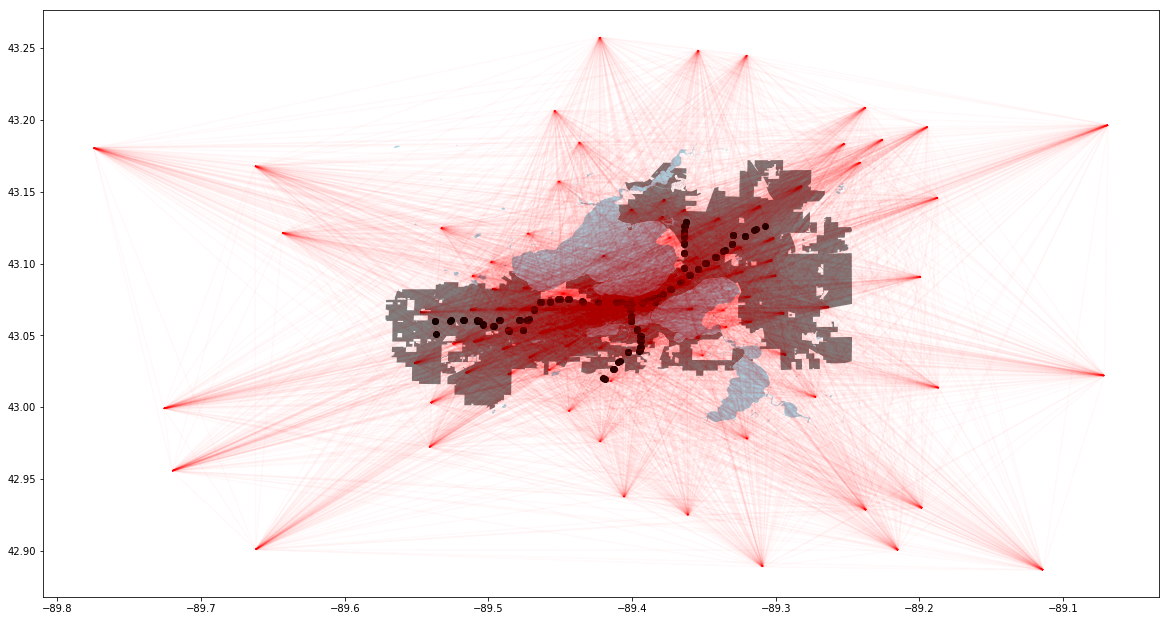

In [47]:
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.01)

In [36]:
import random
import string
lettersAndDigits = string.ascii_letters + string.digits
count=''.join(random.choice(lettersAndDigits) for i in range(10))
count

'p5m49tvkkR'

In [ ]:
#http://data-cityofmadison.opendata.arcgis.com/datasets/3afa8d889c8541ec8cbd89c5845921a2_26
#2015 ridership data by stops

res = requests.get("https://opendata.arcgis.com/datasets/3afa8d889c8541ec8cbd89c5845921a2_26.geojson")
j = res.json()
dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("rideship2015.csv", encoding='utf-8', index=False)            #
ride15=pd.read_csv("rideship2015.csv")
ride15=ride15.set_index(ride15["OBJECTID"])
ride15

In [ ]:
#http://data-cityofmadison.opendata.arcgis.com/items/3afa8d889c8541ec8cbd89c5845921a2
#2017 ridership data by stops

res = requests.get("https://maps.cityofmadison.com/arcgis/rest/services/Public/OPEN_DATA_TRANS/MapServer/26/query?outFields=*&where=1%3D1&f=geojson")
j = res.json()
dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("rideship2017.csv", encoding='utf-8', index=False)            #
ride17=pd.read_csv("rideship2017.csv")
ride17=ride17.set_index(ride17["OBJECTID"])
ride17